# MCF LP Problem Formulation

## Basic definitions

**Definition**: MCF Net

We define a **net** to be a tuple $(V, E, c, K, D)$ where
    
 - $V$ is a non-empty set of vertices.
 - $G \subseteq V \times V - \{ (v, v) \mid v \in V \}$ is a set of (oriented) edges (self-loops are not included).
 - $c$ is a function $c : E \to \mathbb{R}_{0}^{+}$ which assigns a *capacity* to each edge.
 - $K$ is a set of commodities.
 - $D$ is a set of pairs $(s_i, t_i, d_i)$ for $i \in K$ where:
     - $s_i$ denotes the source node for commodity i
     - $t_i$ denotes the target node for commodity i
     - $d_i$ denotes the demant for commodity i
 
**Definition**: Neighbourhood

For oriented graph $G = (V, E)$ we define for each $v \in V$
$$
\begin{gather*}
N^{+}(v) = \{ u \mid (u, v) \in E \} \\
N^{-}(v) = \{ u \mid (v, u) \in E \}
\end{gather*}
$$
meaning $N^{+}$ is a set of all nodes with an edge comming into $v$ and $N^{-}$ is a set of all nodes for which $v$ has an outcomming edge.

**Definition**: Flow

Let $N = (V, E, c, K, D)$ be a net. Then we define **flow** as a function
$$f : E \times K \to \mathbb{R}^{+}$$
satisfying the following conditions:
 - *the flow does not exceed edge cappacities*
     $$\forall e \in E : \sum\limits_{i \in K} f(e, i) \le c(e)$$
 - *the flow satisfies Kirchhoff's law for each commodity and for all but source and destination nodes*
     $$\forall i \in K : \forall v \in (V - \{s_i, t_i\}) : \sum\limits_{u \in N^{+}(v)} f(uv, i) - \sum\limits_{u \in N^{-}(v)} f(vu, i) = 0$$
     
For simplicity we denote $f_e^k := f(e, k)$.

## LP Formulation

Our formulation will be based on pre-computed maximal flows for each commodity $f^k$. The innitial solution will have the flow on each edge $e$ set as the sum of the flows from each commodity $k$. This can, however, lead to capacities of the edges being violated. We therefore add *violation* variable $\nu_e$ a for each edge $e \in E$ that will represent this violation. We aim to minimize the sum of the violation variables.

In the LP formulation we will have the following **variables**:

 - $f_e^k \in \mathbb{Q}, f_e^k \ge 0$ $\sim$ representing the flow of the commodity $k$ through the edge $e$
 - $\nu_e \in \mathbb{Q}, \nu_e \ge 0$ $\sim$ representing the violation on the edge $e$


**Objective function**
$$ \min \sum_{e \in E} \nu_e$$

**Given the conditions**
    
 - *respecting edge capacities given violation*
 $$\forall e \in E : \sum\limits_{k \in K} f_e^k - \nu_e \le c(e)$$
 - *Kirchhoff's law*
 $$\forall k \in K : \forall v \in (V - \{s_i, t_i\}) :  \sum\limits_{u \in N^{+}(v)} f_{uv}^k - \sum\limits_{u \in N^{-}(v)} f_{vu}^k = 0$$
  
Adding additional variables 


**Objective function**
$$ \max \sum_{e \in E} -\nu_e$$

**Conditions**
$$
\begin{align*}
\forall e \in E &: \sum\limits_{k \in K} f_e^k - \nu_e + \varepsilon_e = c(e) \\
\forall k \in K : \forall v \in (V - \{s_i, t_i\}) &:  \sum\limits_{u \in N^{+}(v)} f_{uv}^k - \sum\limits_{u \in N^{-}(v)} f_{vu}^k = 0 \\
\forall k \in K &: \sum_{\{u, t_k\} \in E} f_{u,t_k}^k = d_k
\end{align*}
$$

**Variables**
$$
\begin{align*}
\forall e \in E : \forall k \in K &: f_e^k \in \mathbb{Q} && f_e^k \ge 0 \\
\forall e \in E &: \nu_e \in \mathbb{Q} && \nu_e \ge 0 \\
\forall e \in E &: \varepsilon_e \in \mathbb{Q} && \varepsilon_e \ge 0
\end{align*}
$$

Denoting $n$ the number of nodes and $m$ the number of edges, we have together $m + |P|n$ conditions and $(|P| + 1)m + (|S| + |D|)|P|$ variables.

### Collecting relevant information from instances

In [1]:
import numpy as np
import sympy as sp
from pathlib import Path
from mcf_simplex_analyzer.load_instance import load_instance
from collections import defaultdict
from fractions import Fraction

from pprint import pprint

# Path to data directory
instances_path = Path("example/")

assert instances_path.exists()

instance_format = "planar"
nod_file = instances_path / (instance_format + ".nod")
arc_file = instances_path / (instance_format + ".arc")
sup_file = instances_path / (instance_format + ".sup")
mut_file = instances_path / (instance_format + ".mut")

instance = load_instance(instance_format, nod_file, arc_file, sup_file, mut_file)
print(instance.info)

InstanceInfo(products_no=92, nodes_no=30, links_no=150, bundled_links_no=150)


In [2]:
# Collect edge capacities
capacities = {}
commodities = set()

for arc in instance.arcs:
    fromnode, tonode, commodity, cost, individual_capacity, mutual_ptr = arc
    if fromnode == -1 or tonode == -1:
        print(arc)
    
    if commodity != -1:
        commodities.add(commodity)
        
    mutual, capacity = capacities.get((fromnode, tonode), (None, None))
    if mutual_ptr > 0:
        mutual = instance.mutual.mapping[mutual_ptr]
    
    if individual_capacity >= 0:
        capacity = capacity + individual_capacity if capacity is not None else individual_capacity
    
    capacities[(fromnode, tonode)] = (mutual, capacity)

# Account for mutual cappacity
for key in capacities:
    mutual, total = capacities[key]
    capacities[key] = max(mutual, total) if mutual is not None and total is not None else total

print(capacities)
print(len(capacities))
print(commodities)

{(1, 14): Fraction(48, 1), (14, 1): Fraction(48, 1), (1, 16): Fraction(115, 1), (16, 1): Fraction(115, 1), (1, 22): Fraction(65, 1), (22, 1): Fraction(65, 1), (1, 26): Fraction(86, 1), (26, 1): Fraction(86, 1), (2, 12): Fraction(35, 1), (12, 2): Fraction(35, 1), (2, 16): Fraction(116, 1), (16, 2): Fraction(116, 1), (2, 19): Fraction(42, 1), (19, 2): Fraction(42, 1), (2, 21): Fraction(25, 1), (21, 2): Fraction(25, 1), (2, 26): Fraction(114, 1), (26, 2): Fraction(114, 1), (3, 17): Fraction(80, 1), (17, 3): Fraction(80, 1), (3, 19): Fraction(70, 1), (19, 3): Fraction(70, 1), (3, 22): Fraction(86, 1), (22, 3): Fraction(86, 1), (3, 24): Fraction(105, 1), (24, 3): Fraction(105, 1), (3, 25): Fraction(109, 1), (25, 3): Fraction(109, 1), (3, 30): Fraction(57, 1), (30, 3): Fraction(57, 1), (4, 11): Fraction(97, 1), (11, 4): Fraction(97, 1), (4, 15): Fraction(102, 1), (15, 4): Fraction(102, 1), (4, 18): Fraction(63, 1), (18, 4): Fraction(63, 1), (4, 23): Fraction(103, 1), (23, 4): Fraction(103, 1

In [3]:
# Collect source and destination vertices

source = {}
destination = {}

for supply in instance.supply:
    s, t, k, f = supply
    if k < 0:
        print(supply)
        
    if s == -1:
        destination.setdefault(t, dict())[k] = f
        
    if t == -1:
        source.setdefault(s, dict())[k] = f
        
print(source)
print(destination)

{1: {1: Fraction(4, 1), 2: Fraction(10, 1)}, 2: {3: Fraction(4, 1), 4: Fraction(4, 1), 5: Fraction(9, 1)}, 3: {6: Fraction(8, 1), 7: Fraction(9, 1)}, 4: {8: Fraction(9, 1), 9: Fraction(4, 1), 10: Fraction(10, 1), 11: Fraction(9, 1)}, 5: {12: Fraction(8, 1), 13: Fraction(10, 1), 14: Fraction(11, 1)}, 6: {15: Fraction(9, 1), 16: Fraction(9, 1), 17: Fraction(11, 1)}, 7: {18: Fraction(11, 1), 19: Fraction(6, 1), 20: Fraction(7, 1)}, 8: {21: Fraction(11, 1), 22: Fraction(5, 1), 23: Fraction(4, 1), 24: Fraction(4, 1), 25: Fraction(8, 1), 26: Fraction(7, 1), 27: Fraction(4, 1)}, 9: {28: Fraction(4, 1), 29: Fraction(7, 1), 30: Fraction(9, 1), 31: Fraction(6, 1)}, 11: {32: Fraction(8, 1), 33: Fraction(11, 1), 34: Fraction(9, 1), 35: Fraction(4, 1), 36: Fraction(7, 1), 37: Fraction(11, 1), 38: Fraction(6, 1), 39: Fraction(5, 1)}, 12: {40: Fraction(11, 1)}, 13: {41: Fraction(7, 1), 42: Fraction(8, 1), 43: Fraction(6, 1)}, 14: {44: Fraction(6, 1), 45: Fraction(6, 1), 46: Fraction(10, 1), 47: Fract

In [4]:
in_neighbours = {}
out_neighbours = {}

for arc in instance.arcs:
    fromnode, tonode, _, _, _, _ = arc
    in_neighbours.setdefault(tonode, set()).add(fromnode)
    out_neighbours.setdefault(fromnode, set()).add(tonode)

    
print(in_neighbours)
print(out_neighbours)

{14: {1, 8, 12, 16, 21, 22, 29, 30}, 1: {16, 26, 14, 22}, 16: {1, 2, 14, 21, 26}, 22: {1, 3, 14, 19, 26, 30}, 26: {1, 2, 16, 19, 22}, 12: {2, 21, 14}, 2: {12, 16, 19, 21, 26}, 19: {2, 3, 22, 24, 26}, 21: {16, 2, 12, 14}, 17: {25, 3, 30}, 3: {17, 19, 22, 24, 25, 30}, 24: {19, 3}, 25: {3, 5, 17, 23, 30}, 30: {3, 5, 6, 7, 8, 14, 17, 22, 25}, 11: {9, 28, 4, 20}, 4: {11, 15, 18, 23, 27, 28}, 15: {18, 27, 4, 28}, 18: {27, 4, 15}, 23: {25, 27, 4, 5}, 27: {4, 5, 13, 15, 18, 23, 28}, 28: {4, 6, 8, 10, 11, 13, 15, 20, 27}, 7: {10, 5, 6, 30}, 5: {7, 10, 13, 23, 25, 27, 30}, 10: {5, 6, 7, 13, 28}, 13: {10, 27, 28, 5}, 6: {7, 8, 10, 28, 30}, 8: {6, 14, 20, 28, 29, 30}, 20: {8, 9, 11, 28, 29}, 29: {8, 9, 20, 14}, 9: {11, 20, 29}}
{1: {16, 26, 14, 22}, 14: {1, 8, 12, 16, 21, 22, 29, 30}, 16: {1, 2, 14, 21, 26}, 22: {1, 3, 14, 19, 26, 30}, 26: {1, 2, 16, 19, 22}, 2: {12, 16, 19, 21, 26}, 12: {2, 21, 14}, 19: {2, 3, 22, 24, 26}, 21: {16, 2, 12, 14}, 3: {17, 19, 22, 24, 25, 30}, 17: {25, 3, 30}, 24: {19

# Finding maximal flow for individual commodities

In [5]:
DRAW_GRAPH = False

In [6]:
# Normalize to whole numbers
denoms = ([capacity.denominator for capacity in capacities.values() if capacity is not None] 
          + [ source[s][k].denominator for s in source for k in source[s] ] 
          + [ destination[t][k].denominator for t in destination for k in destination[t] ] 
         )
lcm = np.lcm.reduce(denoms)

# Normalize capacities
for key in capacities:
    capacity = capacities[key]
    if capacity is not None:
        capacities[key] = capacity.numerator * (lcm // capacity.denominator)
        
# Normalize sources
for s in source:
    for k in source[s]:
        supply = source[s][k]
        source[s][k] = supply.numerator * (lcm // supply.denominator)

# Normalize destinations
for t in destination:
    for k in destination[t]:
        demand = destination[t][k]
        destination[t][k] = demand.numerator * (lcm // demand.denominator)
        
network_info = (source, destination, capacities, lcm)

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
for (u, v) in capacities:
    capacity = capacities[(u, v)]
    if capacity is not None:
        graph.add_edge(u, v, capacity=capacity)
    else:
        graph.add_edge(u, v)
        
if DRAW_GRAPH:
    plt.figure(figsize=(13, 8))
    nx.draw_kamada_kawai(graph, node_size=100)

In [8]:
import pprint

def gather_sources(network_info, graph, commodity):
    (source, _, capacities, _) = network_info

    for s in source:
        if commodity in source[s]:
            supply = source[s][commodity].numerator
            graph.add_edge("Source", s, capacity=supply)

            
def gather_destinations(network_info, graph, commodity):
    (_, destination, capacities, _) = network_info
    
    commodity_destinations = []
    for t in destination:
        if commodity in destination[t]: 
            demand = destination[t][commodity]      
            graph.add_edge(t, "Destination", capacity=demand)
            
def get_percantage_full(graph, flow_dict, u, v):
    max_capacity = graph.get_edge_data(u, v).get('capacity', None)
    
    if max_capacity is None:
        return 0
    
    perc = flow_dict[u][v] / max_capacity
    
    return perc

In [1]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def draw_network(graph, flow_dict):
    plt.figure(figsize=(10, 7))
    
    percentage_full=np.array([ get_percantage_full(graph, flow_dict, u, v) for (u,v) in graph.edges])
    norm = Normalize(vmin=0, vmax=1)
    colors = cm.viridis(norm(percentage_full))
    colors[ percentage_full > 1 ] = [1, 0, 0, 1]
    
    
    # DEBUG
    #print(percentage_full)
    
    nx.draw_kamada_kawai(
        graph,
        
        with_labels=True,
        font_size=16,
        font_weight="bold",
        
        node_size=500,
        nodelist=graph.nodes,
        node_color=['lightblue' for _ in graph.nodes],
        
        #edge_color=percentage_full,
        edge_color=colors,
        width=2,
        connectionstyle="arc3,rad=0.1"
    )

MAX_ITER = 4
print(f"Computing first {MAX_ITER} networks ...")

for commodity in range(1, min(instance.info.products_no + 1, MAX_ITER + 1)):
    commodity_graph = graph.copy()
    
    gather_sources(network_info, commodity_graph, commodity)
    gather_destinations(network_info, commodity_graph, commodity)

    # Compute maximal flow     
    flow_value, flow_dict = nx.maximum_flow(commodity_graph, "Source", "Destination")
    
    # DEBUG
    # print(flow_value)
    # print(pprint.pprint(flow_dict))
    
    if DRAW_GRAPH:
        draw_network(commodity_graph, flow_dict)

Computing first 4 networks ...


NameError: name 'instance' is not defined

In [13]:
flow_sum = {}

acc = 0
for commodity in range(1, instance.info.products_no + 1):
    print("Computing flow for commodity", commodity)
    
    commodity_graph = graph.copy()
    
    gather_sources(network_info, commodity_graph, commodity)
    gather_destinations(network_info, commodity_graph, commodity)

    # Compute maximal flow     
    flow_value, flow_dict = nx.maximum_flow(commodity_graph, "Source", "Destination")
    
    for u in flow_dict:
        if u == "Source":
            continue
            
        for v in flow_dict[u]:
            if v == "Destination":
                continue
                
            d = flow_sum.setdefault(u, {})
            d[v] = d.get(v, 0) + flow_dict[u][v]
            
    # DEBUG
    acc += flow_value
    # print(flow_value)
    # print(pprint.pprint(flow_dict))

print(acc)
flow_sum

Computing flow for commodity 1
Computing flow for commodity 2
Computing flow for commodity 3
Computing flow for commodity 4
Computing flow for commodity 5
Computing flow for commodity 6
Computing flow for commodity 7
Computing flow for commodity 8
Computing flow for commodity 9
Computing flow for commodity 10
Computing flow for commodity 11
Computing flow for commodity 12
Computing flow for commodity 13
Computing flow for commodity 14
Computing flow for commodity 15
Computing flow for commodity 16
Computing flow for commodity 17
Computing flow for commodity 18
Computing flow for commodity 19
Computing flow for commodity 20
Computing flow for commodity 21
Computing flow for commodity 22
Computing flow for commodity 23
Computing flow for commodity 24
Computing flow for commodity 25
Computing flow for commodity 26
Computing flow for commodity 27
Computing flow for commodity 28
Computing flow for commodity 29
Computing flow for commodity 30
Computing flow for commodity 31
Computing flow fo

{1: {14: 14, 16: 0, 22: 0, 26: 13},
 14: {1: 24, 8: 83, 12: 12, 16: 35, 21: 21, 22: 64, 29: 21, 30: 37},
 16: {1: 0, 2: 8, 14: 42, 21: 0, 26: 0},
 22: {1: 0, 3: 19, 14: 32, 19: 25, 26: 31, 30: 9},
 26: {1: 0, 2: 11, 16: 0, 19: 0, 22: 9},
 2: {12: 11, 16: 9, 19: 4, 21: 0, 26: 4},
 12: {2: 0, 14: 11, 21: 0},
 19: {2: 19, 3: 0, 22: 32, 24: 4, 26: 0},
 21: {2: 0, 12: 0, 14: 15, 16: 0},
 3: {17: 9, 19: 19, 22: 18, 24: 15, 25: 8, 30: 0},
 17: {3: 11, 25: 18, 30: 0},
 24: {3: 0, 19: 20},
 25: {3: 37, 5: 32, 17: 0, 23: 0, 30: 4},
 30: {3: 11, 5: 18, 6: 0, 7: 37, 8: 0, 14: 39, 17: 5, 22: 38, 25: 7},
 4: {11: 24, 15: 0, 18: 20, 23: 26, 27: 5, 28: 25},
 11: {4: 19, 9: 39, 20: 11, 28: 11},
 15: {4: 7, 18: 0, 27: 0, 28: 0},
 18: {4: 14, 15: 0, 27: 0},
 23: {4: 26, 5: 9, 25: 24, 27: 0},
 27: {4: 0, 5: 20, 13: 0, 15: 0, 18: 0, 23: 0, 28: 6},
 28: {4: 10, 6: 26, 8: 41, 10: 4, 11: 19, 13: 20, 15: 18, 20: 0, 27: 9},
 5: {7: 13, 10: 10, 13: 6, 23: 0, 25: 8, 27: 0, 30: 41},
 7: {5: 6, 6: 11, 10: 0, 30: 7}

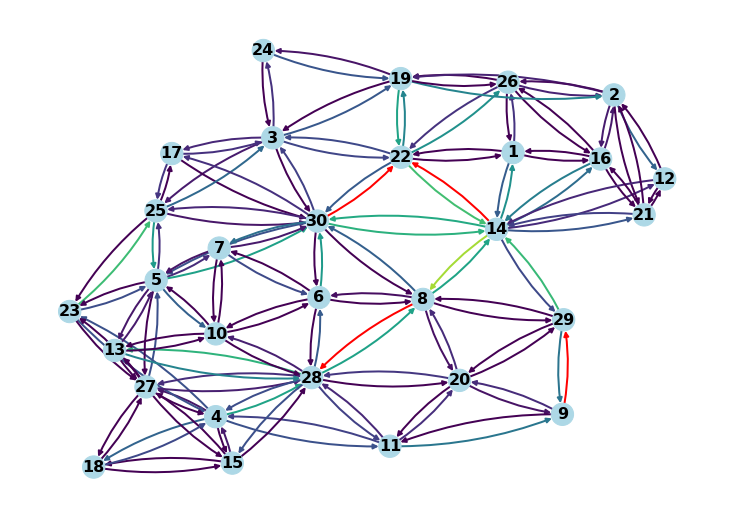

In [11]:
draw_network(graph, flow_sum)